## Mimic EDA
#### Predicting and Understanding Unexpected Respiratory Decompensation in Critical Care Using Sparse and Heterogeneous Clinical Data

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import os 
import random
import datetime
from sqlalchemy import create_engine
import mimic_utils as mimic
import magec_utils as mg
import matplotlib.pyplot as plt
from adjustText import adjust_text

pd.set_option('display.max_columns', None)

random.seed(22891)

%matplotlib inline

Using TensorFlow backend.


### MIMIC-III Data

In [2]:
# MIMIC-III
df_cohort = mimic.get_mimic_data()

### Get annotation data (if any) for patients in our cohort w/ advanced lung or heart disease

In [3]:
df_anno = pd.read_csv('physionet.org/files/phenotype-annotations-mimic/1.20.03/ACTdb102003.csv')
# df_anno = df_anno[((df_anno['ADVANCED.LUNG.DISEASE'] == 1) | 
#                   (df_anno['ADVANCED.HEART.DISEASE'] == 1)) & 
#                   (df_anno['ADVANCED.CANCER'] == 0)]
# users = list(set(df_cohort.subject_id.unique()).intersection(set(df_anno.SUBJECT_ID.unique())))
# len(users)

In [7]:
# np.save('case_users', users)

### MIMIC-III Data Engineering

In [5]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']

labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit

comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']

others = ['age', 'gender']

features = vitals+labs

# Data featurized using 'last' measurements
df_ml = mimic.get_ml_data(df_cohort)

# Data featurized as time-series
df_time = mimic.get_ml_series_data(df_cohort)

# _, x_validation, stsc, _, xst_validation, _, Y_validation = mimic.train_valid_ml(df_ml, 
#                                                                                  include_valid='case_users.npy')

x_train, x_validation, stsc, xst_train, xst_validation, Y_train, Y_validation = mimic.train_valid_ml(df_ml)

stsc2, series_means, _, df_series_valid, _, _, xt_valid, Yt_valid = mimic.train_valid_series(df_time, Y_validation)

In [6]:
len(x_train), len(x_validation)

(8332, 2083)

In [7]:
Y_train['label'].value_counts()

0.0    6729
1.0    1603
Name: label, dtype: int64

In [8]:
Y_validation['label'].value_counts()

0.0    1666
1.0     417
Name: label, dtype: int64

In [10]:
(417+1603) / (6729+1666)

0.24061941631923764

In [102]:
series_means

potassium                     4.325211
magnesium                     1.947868
age                          62.249943
bicarbonate                  23.596949
lactate                       2.411108
tempc_mean                   36.764905
spo2_mean                    96.682942
glucose_mean                141.896560
inr                           1.558460
resprate_mean                19.663873
sodium                      137.574989
pt                           16.076191
diasbp_mean                  62.527891
wbc                          12.162947
chronic_pulmonary             0.199388
bilirubin                     1.592929
phosphate                     3.570678
creatinine                    1.551375
glucose                     161.024982
hemoglobin                   11.872082
ptt                          35.455624
congestive_heart_failure      0.272337
pulmonary_circulation         0.064001
sysbp_mean                  120.695123
gender                        0.562699
chloride                 

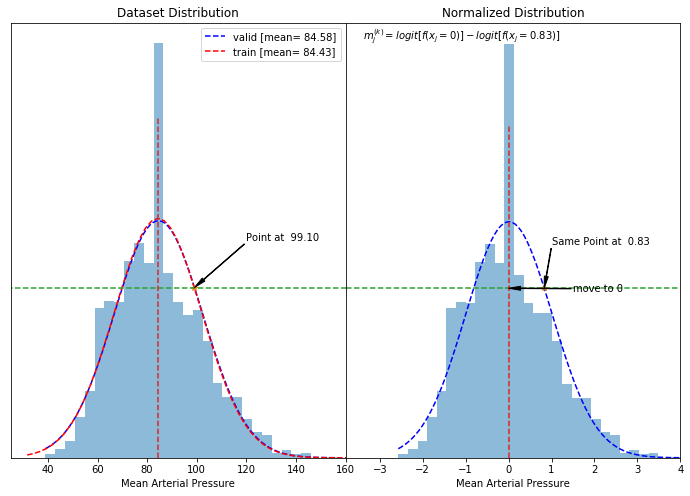

In [84]:
index = 50

feat = 'heartrate_mean'

t_0 = 25

pdf_x_t, pdf_y_t, avg_t, var_t = mg.pdf(x_train[feat])
pdf_x_v, pdf_y_v, avg_v, var_v = mg.pdf(x_validation[feat])

point1 = [pdf_x_v[index], pdf_y_v[index]]

pdf_x_tp, pdf_y_tp, avg_tp, var_tp = mg.pdf(xst_train[feat])
pdf_x_vp, pdf_y_vp, avg_vp, var_vp = mg.pdf(xst_validation[feat])

point2 = [pdf_x_vp[index], pdf_y_vp[index]]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
fig.axes[0].get_yaxis().set_visible(False)
fig.axes[1].get_yaxis().set_visible(False)

arrow_properties = dict(
    facecolor="black", 
    width=0.5,
    headwidth=4)

ax[0].hist(x_validation[feat], 30, density=True, alpha=0.5)
ax[0].plot(pdf_x_v, pdf_y_v, 'b--')
ax[0].plot(pdf_x_t, pdf_y_t, 'r--')
ax[0].legend(['valid [mean={:6.2f}]'.format(avg_v), 'train [mean={:6.2f}]'.format(avg_t)])
ax[0].set_title('Dataset Distribution')
ax[0].set_xlabel('Mean Arterial Pressure')
ax[0].plot(point1[0], point1[1], '*')
ax[0].plot(np.linspace(fig.axes[0].get_xlim()[0],fig.axes[0].get_xlim()[1],10), point1[1]*np.ones(10), '--')
# ax[0].plot(avg_t*np.ones(10), np.linspace(min(pdf_x_t), fig.axes[0].get_ylim()[1], 10), '--')
ax[0].plot(avg_t*np.ones(10), np.linspace(0, 0.032, 10), '--')
ax[0].set_xlim([25,160])
ax[0].set_ylim([0,0.041])

ax[0].annotate(
    "Point at {:6.2f}".format(point1[0]), 
    xy=point1,
    xytext=(120, fig.axes[0].get_ylim()[1]/2),
    arrowprops=arrow_properties)

# ax[0].text(0, 0.0715, r'$m_{j}^{(k)}=logit[f(x_j=32)]-logit[f(x_j=38.89)]$')
ax[1].text(-3.4, 0.7, r'$m_{j}^{(k)}=logit[f(x_j=0)]-logit[f(x_j=0.83)]$')


ax[1].annotate(
    "Same Point at{:6.2f}".format(point2[0]), 
    xy=point2,
    xytext=(1, fig.axes[1].get_ylim()[1]/2.8),
    arrowprops=arrow_properties)

ax[1].annotate(
    "move to 0", 
    xy=(0, point2[1]),
    xytext=(1.5, 0.98*point2[1]),
    arrowprops=arrow_properties)

ax[1].hist(xst_validation[feat], 30, density=True, alpha=0.5)
ax[1].plot(pdf_x_vp, pdf_y_vp, 'b--')
ax[1].set_title('Normalized Distribution')
ax[1].set_xlabel('Mean Arterial Pressure')
ax[1].set_xlim([-3.8, 4])
ax[1].plot(pdf_x_vp[index], pdf_y_vp[index], '*')
ax[1].plot(np.linspace(-3.8, 4, 10), pdf_y_vp[index]*np.ones(10), '--')
ax[1].plot(0*np.ones(10), np.linspace(0, 0.558, 10), '--')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('mimic_magec_perturbation.png')

### Load cohort data (demographics, vitals, labs and co-morbidities)

### Get notes for patients in our cohort

In [86]:
df_notes = mimic.get_cohort_notes()

### Get meds for patients in our cohort

In [87]:
df_meds = mimic.get_cohort_meds()

### Get MAgEC results for validation data (2128 patients)

In [88]:
#joined = pd.read_csv('time_mimic_magecs_valid.csv')
joined = pd.read_csv('time_mimic_magecs.csv')
joined['orig_prob_ensemble'] = joined[['orig_prob_mlp', 'orig_prob_lr', 
                                       'orig_prob_rf', 'orig_prob_lstm']].apply(np.mean, 1)

In [89]:
joined.case.nunique()

2083

In [119]:
rbos = pd.read_json('mimic_rbos_valid.json')

### Cases with most potential

In [90]:
df_anno = pd.read_csv('physionet.org/files/phenotype-annotations-mimic/1.20.03/ACTdb102003.csv')

In [91]:
prob_cols = [c for c in joined.columns if c.startswith('perturb')]

In [92]:
joined[['best_feat', 'new_risk']] = joined.apply(lambda x: mimic.best_feature(x, prob_cols), axis=1)

In [93]:
len(joined)

41029

In [94]:
s1 = set(joined[(joined['orig_prob_ensemble'] > 0.5) & (joined['new_risk'] < 0.5)]['case'].unique())
s2 = joined.groupby('case')['case', 'label'].first()
s2 = set(s2[s2['label']==1]['case'].unique())

In [97]:
len(s1), len(s2), len(s1.intersection(s2))

(595, 417, 173)

In [96]:
joined.groupby('case')['label'].first().value_counts()

0    1666
1     417
Name: label, dtype: int64

In [17]:
joined['risk_diff'] = joined['orig_prob_ensemble'] - joined['new_risk']

### A high risk for mortality case (from mortality risk model): case # 19391

In [103]:
case = 19391
timepoint = 18

In [104]:
pt = mimic.get_pt_admission(case)

In [105]:
pt

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,23713,19391,145500,2161-03-09 19:02:00,2161-03-15 05:20:00,2161-03-15 05:20:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,MARRIED,WHITE,2161-03-09 13:12:00,2161-03-09 21:14:00,HYPOTENSION;SEPSIS;TELEMETRY,1,1


In [106]:
my_cols = ['case', 'timepoint', 'orig_prob_ensemble', 'best_feat', 'new_risk']
joined[(joined.case==case) & (joined.timepoint==timepoint)][my_cols]

,case,timepoint,orig_prob_ensemble,best_feat,new_risk
12985,19391,18,0.372069,diasbp_mean,0.352652


In [107]:
df_cohort[df_cohort.subject_id==case].iloc[[0]]

,subject_id,hadm_id,icustay_id,timepoint,event_time,ventilated,mv_start,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,age,first_icu_stay,adult_icu,first_careunit,diagnosis,curr_service,dischtime,admission_type,mort_icu,gender,admittime,los_icu,mv_hours,los_icu_hr,mv_end,los_hospital,first_hosp_stay,outtime,intime,ventnum,prev_service,transfertime,ethnicity,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,hypothyroidism,renal_failure,liver_disease,peptic_ulcer,aids,lymphoma,metastatic_cancer,solid_tumor,rheumatoid_arthritis,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
67093,19391,145500,224665,26,2161-03-10 22:03:04,0,NaT,19.0,2.1,23.0,NaN,1.0,83.0,98.0,38.9,13.7,2.8,1.4,2.1,242.0,8.3,36.6,5.4,29.4,117.0,32.0,10.8,90.0,102.0,41.0,61.333302,25.0,36.222221,96.0,NaN,79.0,1,1,MICU,HYPOTENSION;SEPSIS;TELEMETRY,MED,2161-03-15 05:20:00,EMERGENCY,1,1,2161-03-09 19:02:00,6.0,NaN,135.0,NaT,6.0,1,2161-03-15 10:43:01,2161-03-09 19:03:04,NaN,None,2161-03-09 19:03:04,white,0.0,1.0,0.0,0.0,0.0,1,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


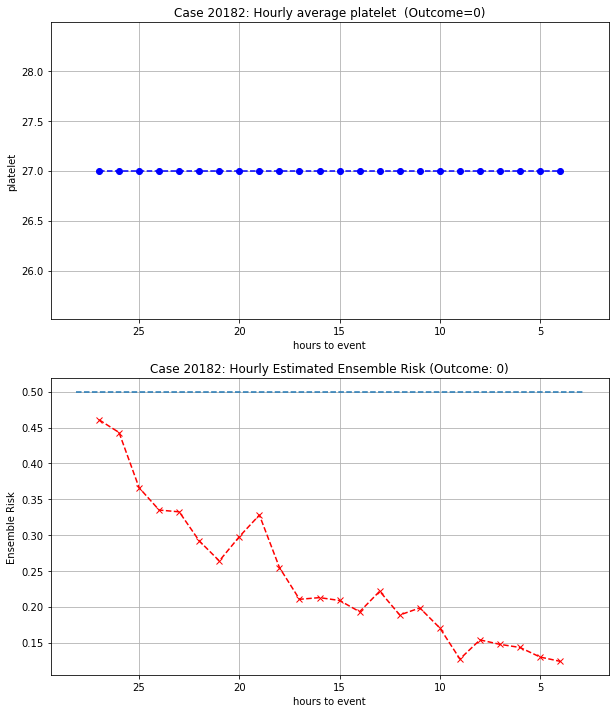

In [108]:
index = 13627
mimic.best_feat_plot(joined, df_cohort, index);

### Find cases for which the predicted ensemble risk is > 0.5 but the estimated perturbed risk is < 0.5

In [109]:
predicate = (joined.orig_prob_ensemble > 0.5) & (joined.new_risk < 0.5)

my_cols = ['case', 'timepoint', 'orig_prob_ensemble', 'best_feat', 'new_risk']

joined[predicate][my_cols].sort_values('new_risk').head()

,case,timepoint,orig_prob_ensemble,best_feat,new_risk
11873,17596,11,0.536173,meanbp_mean,0.128742
24692,45434,24,0.507727,meanbp_mean,0.161280
35135,79310,6,0.503875,spo2_mean,0.173830
14160,20998,10,0.503971,resprate_mean,0.176809
8079,11997,9,0.500611,resprate_mean,0.183601


### Out of those cases what is the distribution of the 'best' variable for perturbation?

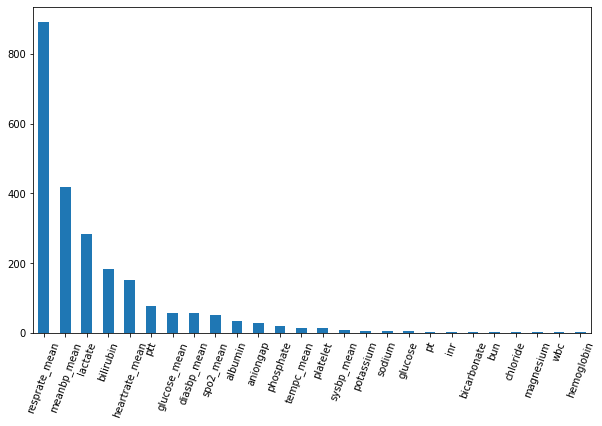

In [110]:
joined[predicate]['best_feat'].value_counts().plot(kind='bar', figsize=(10,6), rot=70)

In [111]:
# joined[predicate][['best_feat', 'new_risk']].groupby('best_feat').mean().\
#     sort_values('new_risk').head(10)

### Cases w/ pneumonia

In [112]:
pneumonia = df_notes[df_notes.text.str.lower().str.contains('pneumonia')].subject_id.unique()
len(pneumonia)

3054

In [113]:
cols = ['subject_id', 'timepoint', 'admittime', 'admission_type', 'los_icu',
        'diagnosis', 'curr_service', 'dischtime', 'mort_icu',
        'mv_start', 'mv_end', 'mv_hours', 'event_time',
        'age', 'gender', 'ethnicity']

### No MV (outcome = 0)

In [114]:
pred = predicate & (np.isin(joined.case, pneumonia)) & (joined.label == 0)
print(np.sum(pred))
joined[pred][my_cols].sort_values('new_risk').head(10)

484


,case,timepoint,orig_prob_ensemble,best_feat,new_risk
11873,17596,11,0.536173,meanbp_mean,0.128742
24692,45434,24,0.507727,meanbp_mean,0.161280
37816,88441,13,0.544980,meanbp_mean,0.200531
24988,46271,8,0.512095,resprate_mean,0.202218
24989,46271,7,0.560097,resprate_mean,0.208563
25178,46880,7,0.531125,meanbp_mean,0.228384
22576,32214,23,0.506965,resprate_mean,0.236542
25156,46763,6,0.528866,resprate_mean,0.242215
37941,89107,3,0.542691,resprate_mean,0.259282
24842,45930,14,0.518700,meanbp_mean,0.260505


#### When 'best_feat' is not 'resprate_mean'

In [115]:
pred = predicate & (np.isin(joined.case, pneumonia)) & (joined.label == 0) & (joined.best_feat != 'resprate_mean')
print(np.sum(pred))
joined[pred][my_cols].sort_values('orig_prob_ensemble', ascending=0).head()

262


,case,timepoint,orig_prob_ensemble,best_feat,new_risk
18595,27400,16,0.715425,meanbp_mean,0.372763
31760,67739,14,0.667290,meanbp_mean,0.374997
1868,2648,26,0.660081,meanbp_mean,0.403956
40335,98041,13,0.656985,glucose_mean,0.474405
24337,44539,18,0.654192,meanbp_mean,0.429183


In [123]:
joined.loc[index].case, joined.loc[index].timepoint

(67739, 14)

In [290]:
rbos[(rbos.case==joined.loc[index].case) & (rbos.timepoint==joined.loc[index].timepoint)]

,case,timepoint,lr_ranked,lstm_ranked,mlp_ranked,rf_ranked,lstm_lr,mlp_lr,mlp_lstm,rf_lr,rf_lstm,rf_mlp
32544,67739,14,"[meanbp_mean, resprate_mean, heartrate_mean, l...","[heartrate_mean, meanbp_mean, lactate, resprat...","[meanbp_mean, heartrate_mean, sysbp_mean, resp...","[resprate_mean, lactate, heartrate_mean, plate...",0.47177,0.508653,0.422732,0.386401,0.332807,0.252244


In [322]:
from scipy import interpolate
from adjustText import adjust_text

def best_feat_plot(joined, cohort, index, title='', save=False, feat=None):
    data = joined.loc[index]
    case, t_0, label, orig_prob, new_risk = data[['case', 'timepoint', 'label',
                                                  'orig_prob_ensemble', 'new_risk']]
    best_feat = joined.loc[index]['best_feat']

    xy = cohort[cohort['subject_id'] == case][['timepoint', best_feat]].values
    x = [int(x[0]) for x in xy]
    yy = [x[1] for x in xy]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    mimic.plot_feature(ax[0], x, yy, best_feat, case, label, title=title)

    xyzw = joined[joined.case == case][['timepoint', 'orig_prob_ensemble', 'best_feat', 'new_risk']].values
    x = [int(x[0]) for x in xyzw]
    y = [x[1] for x in xyzw]
    z = [x[2] for x in xyzw]
    w = [x[3] for x in xyzw]
    zz = [cohort[(cohort['subject_id'] == case) & (cohort['timepoint'] == x[i])][feat].values[0]
          for i, feat in enumerate(z)]

    plot_risk(ax[1], x, y, z, w, zz, case, label, feat=feat)
    ax[1].invert_xaxis()

    if save:
        plt.savefig('case_{}_series.png'.format(case))

    return fig, ax

def plot_risk(ax, x, y, z, w, yy, case, label, feat=None):
    ax.plot(x, y, 'rx--')
    ax.plot(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 10), 0.5 * np.ones(10), '--')
    txt = 'Case {}: Hourly Estimated Ensemble Risk (Outcome: {})'
    ax.set_title(txt.format(case, label))
    ax.set_ylabel('Ensemble Risk')
    ax.set_xlabel('hours to event')
    ax.grid('on')
    # ax.set_ylim([0.2, 0.9])

    texts = []

    for i, txt in enumerate(z):
        if np.isnan(yy[i]):
            continue
        if feat is not None and feat == txt:    
            msg = txt + ' = {:.2f}\n perturb. risk = {:.2g}'.format(yy[i], w[i])
            texts.append(ax.text(x[i], y[i], msg))
        elif feat is None and (w[i] < 0.5 < y[i]):
            msg = txt + ' = {:.2f}\n perturb. risk = {:.2g}'.format(yy[i], w[i])
            texts.append(ax.text(x[i], y[i], msg))

    if feat is None:
        f = interpolate.interp1d(x, y)
        x = np.linspace(min(x), max(x), 140)
        y = f(x)
        adjust_text(texts, x, y, arrowprops=dict(arrowstyle="->", color='b', lw=0.5), autoalign='xy')
    return


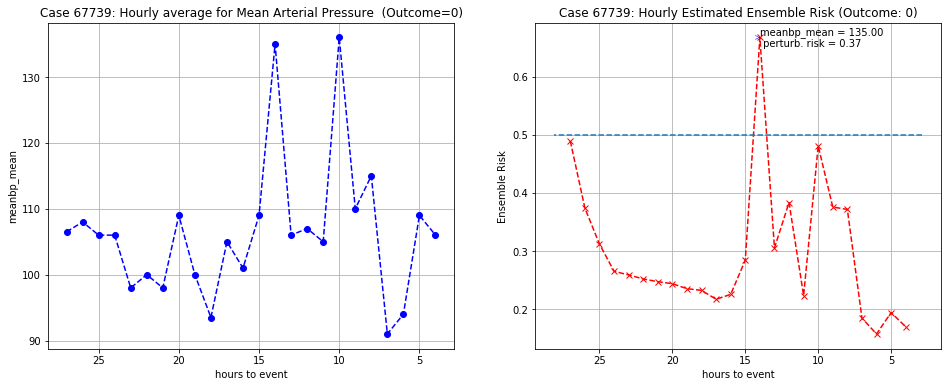

In [289]:
index = 31760
fig1, ax1 = best_feat_plot(joined, df_cohort, index, title='for Mean Arterial Pressure', save=True);

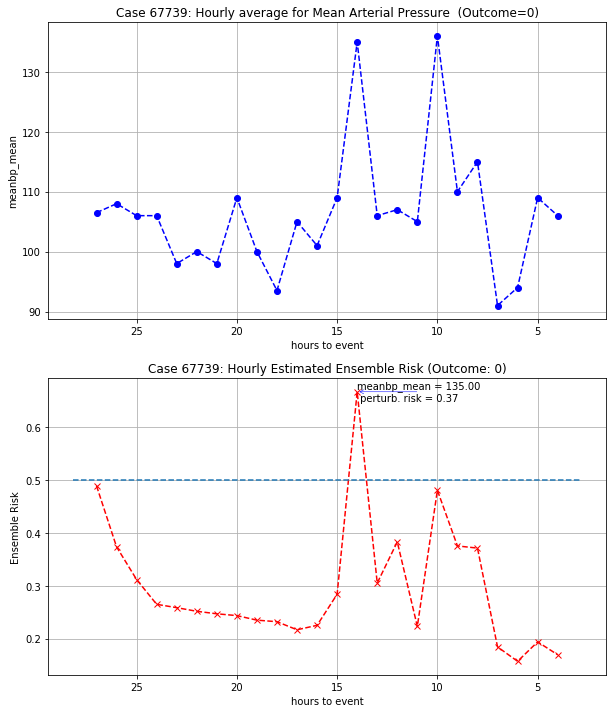

In [127]:
index = 31760
fig1, ax1 = mimic.best_feat_plot(joined, df_cohort, index, title='for Mean Arterial Pressure', save=True);

In [284]:
27-14

13

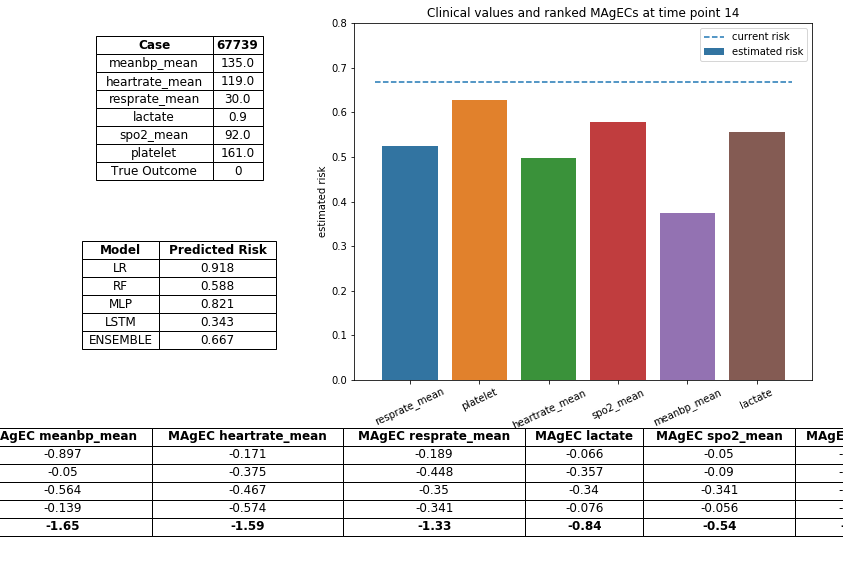

In [285]:
timepoint = 14
txt = 'Clinical values and ranked MAgECs at time point {}'
fig2, main_fig, ml_fig, mg_fig, bar_fig  = panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
                  models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=6, rotate=25, 
                  title=txt.format(timepoint))

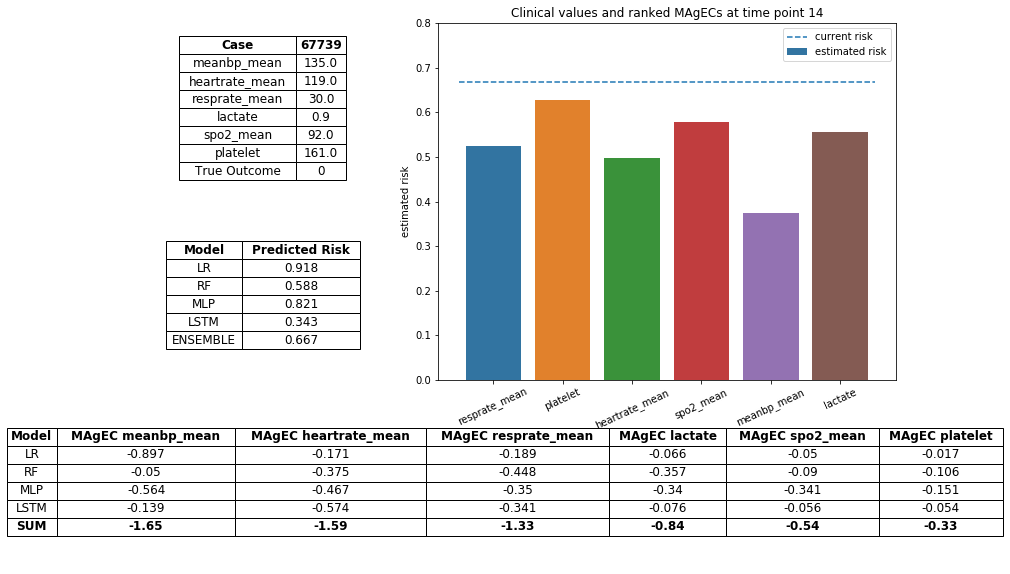

In [286]:
fig2

In [287]:
fig2.savefig('case_{}_t_{}.png'.format(joined.loc[index].case, timepoint), bbox_inches='tight')

In [ ]:
timepoint = 3
mg.panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)

## Examples of Pneumonia w/ best feature for BP w/ and w/o MV

### Outcome = 0

In [291]:
pred = predicate & (np.isin(joined.case, pneumonia)) & (joined.label == 0) & (joined.best_feat == 'meanbp_mean')
print(np.sum(pred))
joined[pred][my_cols].sort_values('orig_prob_ensemble', ascending=0).head()

62


,case,timepoint,orig_prob_ensemble,best_feat,new_risk
18595,27400,16,0.715425,meanbp_mean,0.372763
31760,67739,14,0.667290,meanbp_mean,0.374997
1868,2648,26,0.660081,meanbp_mean,0.403956
24337,44539,18,0.654192,meanbp_mean,0.429183
34253,76437,18,0.647051,meanbp_mean,0.310815


In [ ]:
index = 32544
fig, ax =  mimic.best_feat_plot(joined, df_cohort, index)

In [ ]:
# fig.savefig('case_{}_series.png'.format(joined.loc[index].case))

In [ ]:
timepoint = 14
mg.panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), 
              label='label', limit=8, rotate=25, title='Case # 67739 at t=14', save='case_67739_14')
timepoint = 4
mg.panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), 
              label='label', limit=8, rotate=25, title='Case # 67739 at t=4', save='case_67739_4')

In [ ]:
mimic.print_notes(df_notes, joined.loc[index].case)

In [ ]:
set(df_meds[df_meds.subject_id==joined.loc[index].case]['drug_name_generic'].tolist())

### Outcome = 1

In [292]:
pred = predicate & (np.isin(joined.case, pneumonia)) & (joined.label == 1) & (joined.best_feat == 'meanbp_mean')
print(np.sum(pred))
joined[pred][my_cols].sort_values('orig_prob_ensemble', ascending=0).head()

30


,case,timepoint,orig_prob_ensemble,best_feat,new_risk
138,130,13,0.701815,meanbp_mean,0.418932
139,130,12,0.678306,meanbp_mean,0.415276
140,130,11,0.673520,meanbp_mean,0.418159
21691,31241,14,0.672980,meanbp_mean,0.435638
21695,31241,10,0.669629,meanbp_mean,0.435244


In [ ]:
index = 11031
fig, ax = mimic.best_feat_plot(joined, df_cohort, index);

In [ ]:
fig.savefig('case_{}_series.png'.format(joined.loc[index].case))

In [ ]:
timepoint = 11
mg.panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), 
              label='label', limit=8, rotate=25, title='Case # 15396 at t=11', save='case_15396_11')
timepoint = 4
mg.panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), 
              label='label', limit=8, rotate=25, title='Case # 15396 at t=4', save='case_15396_4')

In [ ]:
df_cohort[(df_cohort.subject_id==joined.loc[index].case)][cols].iloc[[0]]

In [ ]:
set(df_meds[df_meds.subject_id==joined.loc[index].case]['drug_name_generic'].tolist())

In [ ]:
mimic.print_notes(df_notes, joined.loc[index].case)

### With MV (outcome = 1)

In [293]:
pred = predicate & (np.isin(joined.case, pneumonia)) & (joined.label == 1)
print(np.sum(pred))
joined[pred][my_cols].sort_values('new_risk').head()

328


,case,timepoint,orig_prob_ensemble,best_feat,new_risk
35135,79310,6,0.503875,spo2_mean,0.173830
20479,29447,9,0.514270,resprate_mean,0.271737
37140,85647,6,0.507146,resprate_mean,0.283590
21679,31241,26,0.524348,bilirubin,0.292255
20478,29447,10,0.592541,resprate_mean,0.293057


#### When 'best_feat' is not 'resprate_mean'

In [294]:
pred = predicate & (np.isin(joined.case, pneumonia)) & (joined.label == 1) & (joined.best_feat != 'resprate_mean')
print(np.sum(pred))
joined[pred][my_cols].sort_values('orig_prob_ensemble', ascending=0).head(10)

143


,case,timepoint,orig_prob_ensemble,best_feat,new_risk
138,130,13,0.701815,meanbp_mean,0.418932
139,130,12,0.678306,meanbp_mean,0.415276
140,130,11,0.673520,meanbp_mean,0.418159
21691,31241,14,0.672980,meanbp_mean,0.435638
21695,31241,10,0.669629,meanbp_mean,0.435244
35274,79565,4,0.664418,meanbp_mean,0.491739
21696,31241,9,0.661206,bilirubin,0.444460
21697,31241,8,0.658811,meanbp_mean,0.433552
21690,31241,15,0.656262,bilirubin,0.493670
40373,98169,17,0.648289,lactate,0.490639


In [295]:
pred = predicate & (np.isin(joined.case, pneumonia)) & (joined.label == 1) & (joined.best_feat == 'spo2_mean')
print(np.sum(pred))
joined[pred][my_cols].sort_values('orig_prob_ensemble', ascending=0).head()

5


,case,timepoint,orig_prob_ensemble,best_feat,new_risk
16766,24560,14,0.562193,spo2_mean,0.442415
16765,24560,15,0.556487,spo2_mean,0.448287
16764,24560,16,0.516028,spo2_mean,0.455542
2838,4245,6,0.515758,spo2_mean,0.480975
35135,79310,6,0.503875,spo2_mean,0.173830


In [ ]:
index = 30725
mimic.best_feat_plot(joined, df_cohort, index);

In [ ]:
timepoint = 24
mg.panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)

In [ ]:
timepoint = 3
mg.panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)

In [ ]:
index = 11031
mimic.best_feat_plot(joined, df_cohort, index, title='Mean Arterial Pressure', save=True)

In [ ]:
df_cohort[(df_cohort.subject_id==joined.loc[index].case)][cols].iloc[[0]]

In [ ]:
mimic.print_notes(df_notes, joined.loc[index].case)

### Select a feature and identify a use case

In [ ]:
feat = 'magnesium'
joined[predicate][joined[predicate]['best_feat'] == feat][my_cols].\
    sort_values('new_risk').head(10)

### Is sysbp_mean ever identified by MAgEC w/ estimated risk below 0.5?

In [ ]:
joined[predicate][joined[predicate]['best_feat'] == 'sysbp_mean'][my_cols].\
    sort_values('new_risk').head(10)

### Time-series plot

In [ ]:
index = 14075
mimic.best_feat_plot(joined, df_cohort, index)

In [ ]:
index = 22050
mimic.best_feat_plot(joined, df_cohort, index)

In [ ]:
df_cohort[df_cohort.subject_id==30591]

In [ ]:
mimic.print_notes(df_notes, 30591)

In [ ]:
index = 16262
mimic.best_feat_plot(joined, df_cohort, index)

In [ ]:
index = 14075
case = 19845
mimic.feat_plot(joined, df_cohort, index)

In [ ]:
print_notes(case)

In [ ]:
cols = ['subject_id', 'timepoint', 'admittime', 'admission_type', 'los_icu',
        'diagnosis', 'curr_service', 'dischtime', 'mort_icu',
        'mv_start', 'mv_end', 'mv_hours', 'event_time',
        'age', 'gender', 'ethnicity']

data = df_cohort[(df_cohort.subject_id==case) & (df_cohort.timepoint==15)][cols]
data

In [ ]:
txt1 = (data.event_time - datetime.timedelta(hours=int(data.timepoint.values[0])) -
        data.admittime 
       ).iloc[0]

txt1 = (txt1.days)*24 + (txt1.seconds) // 3600

txt2 = (data.event_time - datetime.timedelta(hours=3) -
        data.admittime 
       ).iloc[0]

txt2 = (txt2.days)*24 + (txt2.seconds) // 3600

In [ ]:
txt1, txt2

In [ ]:
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint=int(data.timepoint.values[0]),
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25, 
              save='case{}_t_{}'.format(case, int(data.timepoint.values[0])), 
              title='Case #{} {} hours after ICU admission'.format(case, txt1))

In [ ]:
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint=3,
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25, 
              save='case{}_t_{}'.format(case, 3), 
              title='Case #{} {} hours after ICU admission'.format(case, txt2))

In [ ]:
set(df_meds[df_meds.subject_id==case]['drug_name_generic'].tolist())

### Find interesting patients for whom we have annotations

In [ ]:
cols = ['subject_id', 'timepoint', 'admittime', 'admission_type', 'los_icu',
        'diagnosis', 'curr_service', 'dischtime', 'mort_icu',
        'mv_start', 'mv_end', 'mv_hours',
        'age', 'gender', 'ethnicity']

valid_cases = df_cohort[np.isin(df_cohort.subject_id, users)].\
               sort_values(['subject_id', 'timepoint']).\
               groupby(['subject_id'])[cols].first()

In [ ]:
valid_cases[valid_cases['mv_hours'] > 0]

### Potential new cases

In [ ]:
# 6451, 19823
case = 29043
df_anno[df_anno.SUBJECT_ID==case].iloc[0]

In [ ]:
set(df_meds[df_meds.subject_id==case]['drug_name_generic'].tolist())

In [ ]:
t_min = df_cohort[df_cohort.subject_id==case]['timepoint'].min()
t_max = df_cohort[df_cohort.subject_id==case]['timepoint'].max()
print(t_min, t_max)

In [ ]:
timepoint = t_max
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)

In [ ]:
timepoint = t_min
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)

In [ ]:
df_cohort.diagnosis.unique().tolist()

In [ ]:
df_cohort[(df_cohort.diagnosis=='PNEUMONIA') & (df_cohort.mv_hours > 0)].head()

In [ ]:
index = 3389
mimic.best_feat_plot(joined, df_cohort, index)

In [ ]:
joined[predicate][joined[predicate]['best_feat'] == 'spo2_mean'][my_cols].\
    sort_values(['new_risk','orig_prob_ensemble'], ascending=[0,1]).head(10)

In [ ]:
df_cohort[(df_cohort.diagnosis=='PNEUMONIA') 
          & (joined[predicate]['best_feat'] == 'spo2_mean')].head()

In [ ]:
joined[(joined.case == 67796) & (joined.timepoint == 14)]

In [ ]:
index = 36294
mimic.best_feat_plot(joined, df_cohort, index)

In [ ]:
mimic.print_notes(df_notes, 80174)

In [ ]:
joined[predicate][joined[predicate]['best_feat'] == 'tempc_mean'][my_cols].\
    sort_values('new_risk').head(10)

In [ ]:
index = 41116
mimic.best_feat_plot(joined, df_cohort, index)

In [ ]:
mimic.print_notes(df_notes, 98041)

In [261]:
index

31760

In [269]:
import seaborn as sns
from matplotlib.font_manager import FontProperties

def panel_plot(train_cols, features, stsc, joined, case, timepoint=None,
               models=('lr', 'rf', 'mlp'), label='Outcome',
               limit=None, rotate=None, save=None, title=None, magec_ensemble=False):

    if timepoint is None:
        data = joined.loc[joined.case == case]
    else:
        data = joined.loc[(joined.case == case) & (joined.timepoint == timepoint)]

    case_df = mg.case_stats(data, case, timepoint, models=models)

    if limit is not None:
        topK = case_df.groupby('feature')['risk_new'].mean().sort_values()[:limit].index.values
        case_df = case_df[np.isin(case_df['feature'], topK)]
        train_cols_idx = [train_cols.to_list().index(x) for x in topK]
        features = topK
    else:
        train_cols_idx = [i for i in range(len(train_cols))]

    fig = plt.figure(figsize=(14, 10))
    grid = plt.GridSpec(3, 5, wspace=0.2, hspace=0.1)

    main_fig = fig.add_subplot(grid[0, 0:2])
    ml_fig = fig.add_subplot(grid[1, 0:2])
    mg_fig = fig.add_subplot(grid[2, :])
    bar_fig = fig.add_subplot(grid[:2, 2:])

    base = case_df.groupby('feature')['risk'].mean()

    bar_fig = sns.barplot(x="feature", y="risk_new", data=case_df, ci=None, ax=bar_fig)
    bar_fig.plot(np.linspace(bar_fig.get_xlim()[0], bar_fig.get_xlim()[1], 10),
                 np.mean(base.values) * np.ones(10), '--')
    bar_fig.legend(['current risk', 'estimated risk'], loc='upper right')
    bar_fig.set_ylabel('estimated risk')
    bar_fig.set_ylim([0, min(round(1.2*bar_fig.get_ylim()[1], 1), 1)])
    if rotate is not None:
        bar_fig.set_xticklabels(bar_fig.get_xticklabels(), rotation=rotate)
    bar_fig.set_xlabel('')

    collabel0 = ["Case", str(case)]

    cell_feat = [feat for feat in train_cols[train_cols_idx]]
    cell_vals = [round(val, 3) for val in stsc.inverse_transform(data[train_cols])[0][train_cols_idx]]
    celldata0 = [[x[0], x[1]] for x in zip(cell_feat, cell_vals)] + [['True Outcome', data[label].values[0]]]

    collabel1 = ["Model", "Predicted Risk"]

    celldata1 = [[model.upper(), round(data['orig_prob_'+model].values[0], 3)] for model in models]

    collabel2 = ["Model"] + ["MAgEC " + feat for feat in features] #+ ["Sum"]
    
    celldata2 = list()

    if not magec_ensemble:
        models = [m for m in models if m != 'ensemble']

    for model in models:
        add_model = True
        line = list()
        for feat in features:
            f = model + '_' + feat
            if f not in data:
                add_model = False
                break
            else:
                line.append(round(data[f].values[0], 3))
        if add_model:
            celldata2.append([model.upper()] + line)

    celldata2_sum = np.sum(np.array([t[1:] for t in celldata2]), axis=0)
    celldata2.append(['SUM'] + [round(t, 2) for t in celldata2_sum])
    
    main_fig.axis('tight')
    main_fig.axis('off')
    ml_fig.axis('tight')
    ml_fig.axis('off')
    mg_fig.axis('tight')
    mg_fig.axis('off')

    table0 = main_fig.table(cellText=celldata0, colLabels=collabel0, loc='center', cellLoc='center')
    table1 = ml_fig.table(cellText=celldata1, colLabels=collabel1, loc='center', cellLoc='center')
    table2 = mg_fig.table(cellText=celldata2, colLabels=collabel2, loc='center', cellLoc='center')

    table0.set_fontsize(12)
    table0.scale(1.5, 1.5)

    table1.set_fontsize(12)
    table1.scale(1.5, 1.5)

    table2.set_fontsize(12)
    table2.scale(1.5, 1.5)

    table0.auto_set_column_width(col=list(range(len(collabel0))))
    table1.auto_set_column_width(col=list(range(len(collabel1))))
    table2.auto_set_column_width(col=list(range(len(collabel2))))

    mg.bold_column(table0)
    mg.bold_column(table1)
    mg.bold_column(table2)
    
    for (row, col), cell in table2.get_celld().items():
        if (row == 5):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    if title is not None:
        plt.title(title)

    if save is not None:
        plt.savefig(str(save)+'.png', bbox_inches='tight')

    return fig, main_fig, ml_fig, mg_fig, bar_fig 

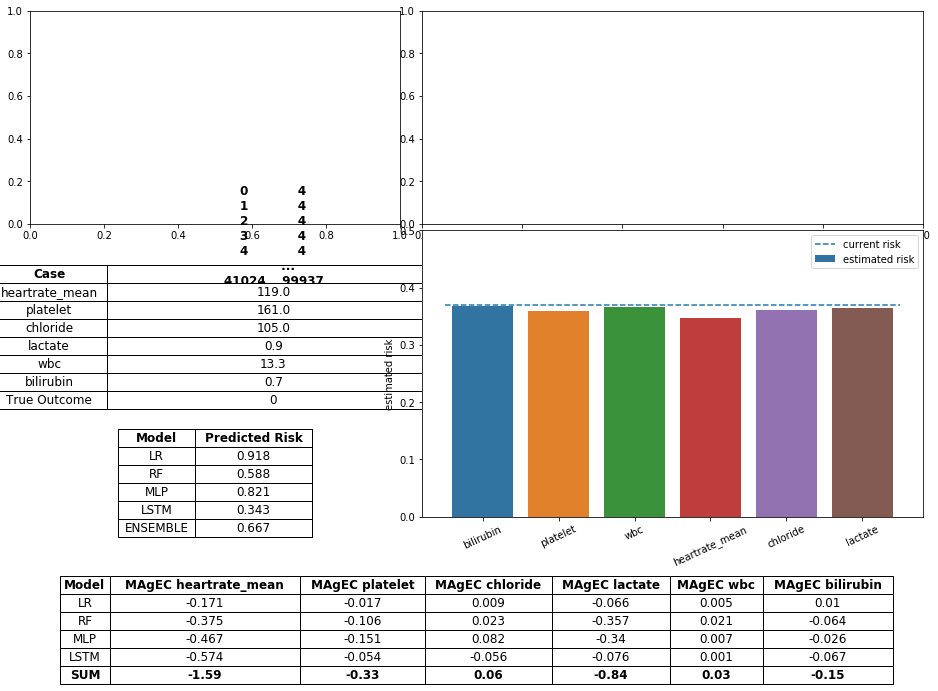

In [260]:
timepoint = 14
txt = 'Clinical values and ranked MAgECs {} hours after ICU admission'
fig = full_panel_plot(xst_validation.columns, features, stsc2, joined, df_cohort, index, 
                  models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=6, rotate=25, 
                  title=txt.format(timepoint));

In [298]:
joined[joined.case==15396][my_cols]

,case,timepoint,orig_prob_ensemble,best_feat,new_risk
10398,15396,26,0.571388,resprate_mean,0.455092
10399,15396,24,0.522113,resprate_mean,0.391738
10400,15396,22,0.538888,resprate_mean,0.403964
10401,15396,20,0.512271,resprate_mean,0.397021
10402,15396,18,0.569387,resprate_mean,0.398698
10403,15396,16,0.558427,resprate_mean,0.385883
10404,15396,14,0.654666,resprate_mean,0.439259
10405,15396,12,0.613294,resprate_mean,0.407188
10406,15396,11,0.821987,meanbp_mean,0.607430
10407,15396,10,0.796462,resprate_mean,0.427542


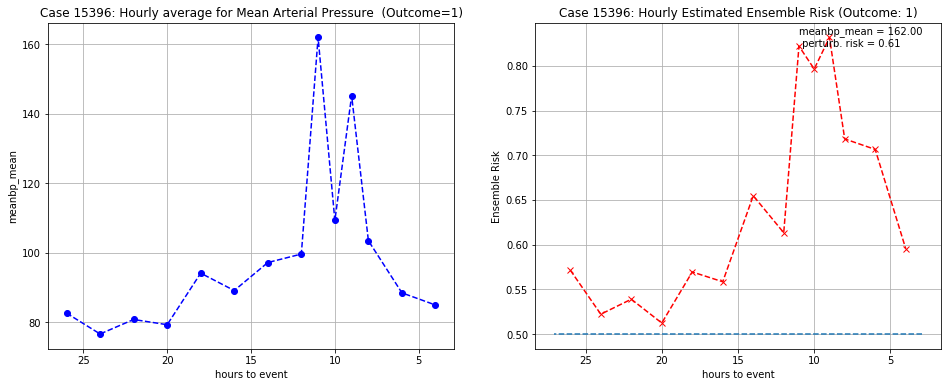

In [329]:
index = 10406
fig2, ax2 = best_feat_plot(joined, df_cohort, index, title='for Mean Arterial Pressure', save=True, 
                           feat='meanbp_mean');

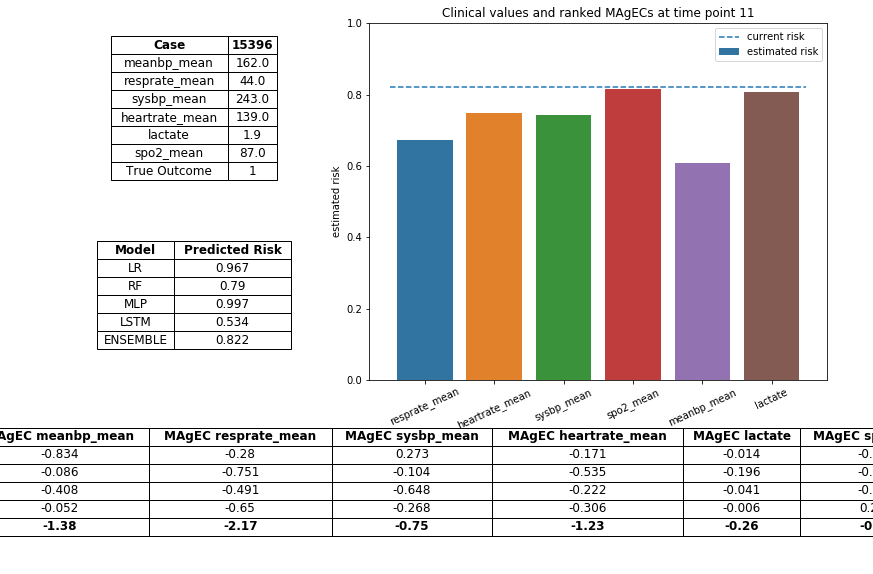

In [330]:
timepoint = 11
txt = 'Clinical values and ranked MAgECs at time point {}'
fig2, main_fig, ml_fig, mg_fig, bar_fig  = panel_plot(xst_validation.columns, features, stsc2, joined, joined.loc[index].case, timepoint, 
                  models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=6, rotate=25, 
                  title=txt.format(timepoint))

In [328]:
fig2.savefig('case_{}_t_{}.png'.format(joined.loc[index].case, timepoint), bbox_inches='tight')

In [331]:
rbos[(rbos.case==joined.loc[index].case) & (rbos.timepoint==joined.loc[index].timepoint)]

,case,timepoint,lr_ranked,lstm_ranked,mlp_ranked,rf_ranked,lstm_lr,mlp_lr,mlp_lstm,rf_lr,rf_lstm,rf_mlp
11031,15396,11,"[meanbp_mean, resprate_mean, heartrate_mean, s...","[resprate_mean, chloride, sodium, magnesium, l...","[meanbp_mean, heartrate_mean, resprate_mean, s...","[resprate_mean, heartrate_mean, lactate, spo2_...",0.281081,0.546536,0.264896,0.398675,0.449067,0.455285
